<a href="https://colab.research.google.com/github/HIsu1231/Hands-On-ML/blob/main/Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##기본 설정

In [1]:
#파이썬 3.5이상 필수
import sys
assert sys.version_info >= (3,5)


#사이킷런 0.20이상 필수
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.chdir('./drive/MyDrive/hands_on')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):

    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    
    if tight_layout:
        plt.tight_layout()

    plt.savefig(path, format=fig_extension, dpi=resolution)

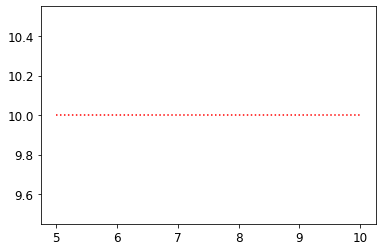

In [2]:

plt.plot([5,10],[10,10],"r:")

#MNIST

In [3]:
os.getcwd()

'/content/drive/MyDrive/hands_on'

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

<사이킷런 데이터셋의 딕셔너리 구조>

  1. 데이터셋을 설명하는 DESCR 키
  2. 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
  3. 레이블 배열을 담은 target 키 

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape #28X28픽셀 이므로 70000개의 이미지가 784개의 특성을 갖고있음

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
28 * 28

784

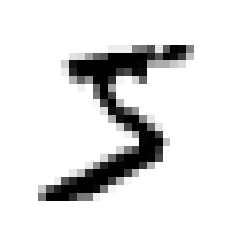

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [10]:
#레이블 문자 -> 정수 변환
y = y.astype(np.uint8)

In [11]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [12]:
#숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28

    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1

    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))

    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    
    plt.imshow(image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


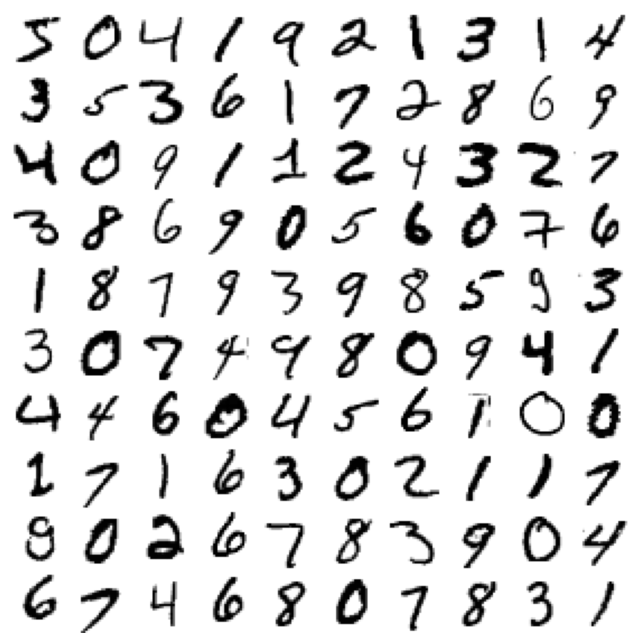

In [13]:
plt.figure(figsize=(9,9))
example_images = X[:100]

plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [14]:
y[0]

5

In [15]:
#훈련세트 앞쪽 60000개 테스트 세트 뒤쪽 10000개 나누기
X_train, X_test, y_train, y_test = X[:60000], X[600000:], y[:60000], y[60000]

#이진 분류기

In [16]:
y_train_5 = (y_train == 5) #5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

SGDClassifier 클래스를 사용한 확률적 경사 하강법 분류기 

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
sgd_clf.predict([some_digit]) #some_digit=X[5]

array([ True])

#성능 측정

##교차 검증

In [19]:
#사이킷런 교차검증 함수 사용
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
#교차검증 함수 직접 구현
from sklearn.model_selection import StratifiedKFold  #클래스별 비율이 유지되도록 계층적 샘플링 수행
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print("Accurcy = ", n_correct/len(y_pred))

Accurcy =  0.9669
Accurcy =  0.91625
Accurcy =  0.96785


In [21]:
#모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)  

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [23]:
never_5_clf.predict(X_train)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

## 오차 행렬
분류기의 성능을 평가하는 좋은 방법. 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [24]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [25]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

#             5아님으로 분류    5라고 분류
#음성 클래스    진짜 음성       거짓 양성
#양성 클래스    거짓 음성       진짜 양성

array([[53892,   687],
       [ 1891,  3530]])

In [26]:
y_train_perfect_predictions = y_train_5  #완벽한 분류기일 경우(완벽한 척)
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

##정밀도와 재현율

정밀도: 양성 예측의 정확도 -> **정밀도 =  TP / (TP + FP)**
<br>TP: 진짜 양성의 수
<br>TF: 거짓 양성의 수

재현율: 분류기가 정확하게 감지한 양성 샘플의 비율(민감도 or 진짜 양성 비율)
<br> **재현율 = TP / (TP +FN)**
<br>FN 거짓 음성의 수

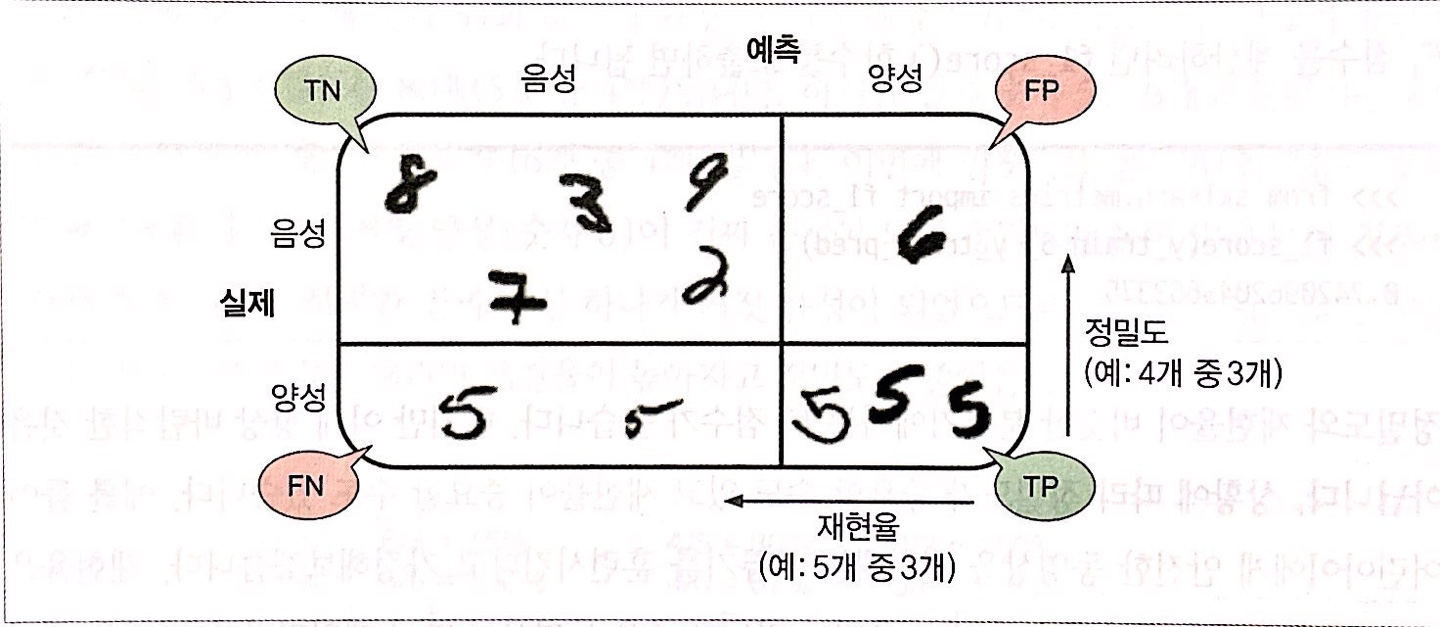

In [27]:
from sklearn.metrics import precision_score, recall_score

#정밀도 계산
precision_score(y_train_5, y_train_pred)  # 3530 / (687 + 3530)

0.8370879772350012

In [28]:
#오차행렬을 이용하여 직접 정밀도 계산
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1,1] / (cm[0,1] + cm[1,1])

0.8370879772350012

In [29]:
#재현율 계산
recall_score(y_train_5, y_train_pred) #3530 / (1891 + 3530)

0.6511713705958311

In [30]:
#오차행렬을 이용하여 직접 재현율 계산
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1,1] / (cm[1,0] + cm[1,1])

0.6511713705958311

F1 점수: 정밀도와 재현율의 조화 평균

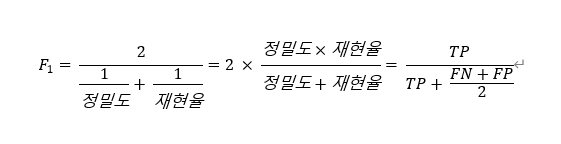

In [31]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [32]:
#F1 점수 직접 계산
cm[1,1] / (cm[1,1] + (cm[1,0] + cm[0,1]) / 2)

0.7325171197343847

##정밀도/재현율 트레이드오프

정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄고
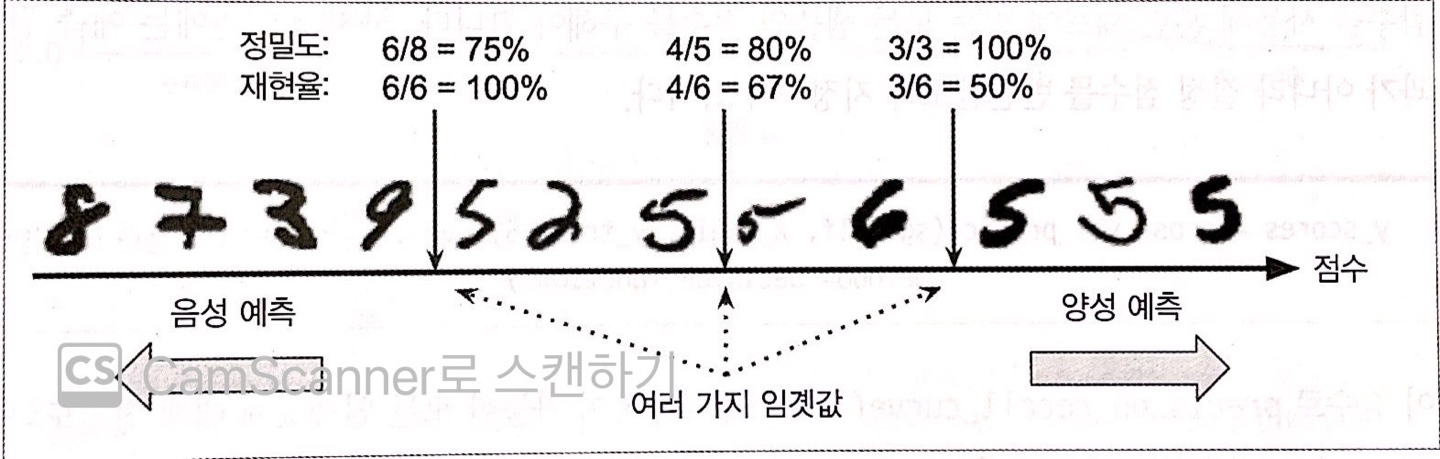

In [34]:
#decision_function() 메서드를 호출하여 각 샘플의 점수 얻기
#이 점수를 기반으로 원하는 임곗값을 정해 예측할 수 있음

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [35]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [36]:
y_some_digit_pred

array([ True])

In [37]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

#임곗값을 높이면 재현율이 줄어든다.

array([False])

적절한 임계값 정하는 법: cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구한다.(결정 점수를 반환하도록 설정)

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곘값에 대해 정밀도와 재현율 계산이 가능

In [39]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

그림 저장: precision_recall_vs_threshold_plot


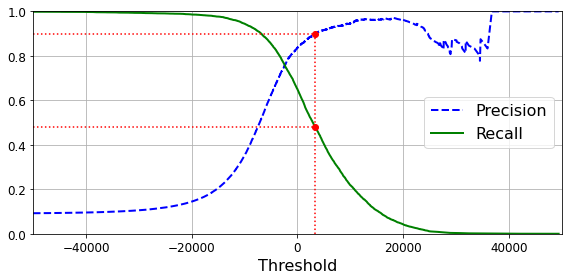

In [40]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])


recall_90_precision = recalls[np.argmax(precisions >= 0.90)] 
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] #정밀도가 최소 90%가 되는 가장 낮은 임계값 표시

plt.figure(figsize=(8,4))

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision],"ro")
save_fig("precision_recall_vs_threshold_plot")
plt.show()

재현율에 대한 정밀도 곡선

그림 저장: precision_vs_recall_plot


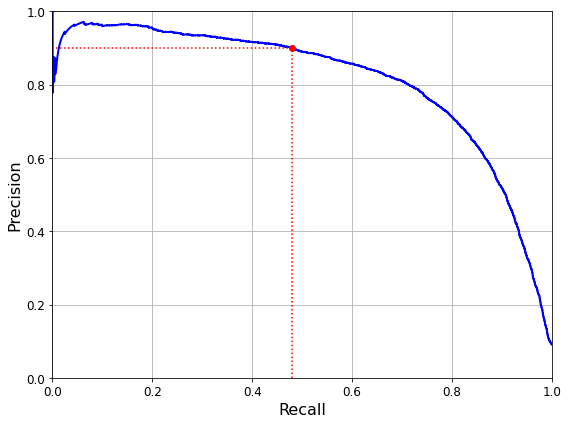

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)

plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [43]:
#훈련 세트에 대한 예측 predict()함수 대신
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

##ROC(수신기 조작 특성) 곡선

거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)
<br>**거짓 양성 비율(FPR) = 1 - 진짜 음성 비율(TNR)**
<br> => TNR을 특이도라고도 하기 때문에 ROC 곡선은 민감도에 대한 1-특이도 그래프. 

In [46]:
from sklearn.metrics import roc_curve
#FPR, TPR, 임곗값 계산
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


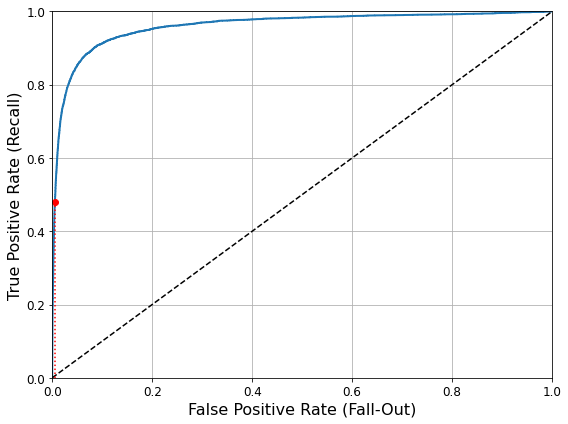

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #대각 점선
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16) 
    plt.grid(True)   

plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
save_fig("roc_curve_plot")
plt.show()

점선은 완전한 랜덤 분류기의 ROC 곡선을 나타냄. 
<br> 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함(왼쪽 위 모서리)
<br> -> 곡선 아래의 면적(AUC)를 측정하면 분류기들을 비교할 수 있음

In [48]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [50]:
y_scores_forest = y_probas_forest[:, 1] #양성 클래스의 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

그림 저장: roc_curve_comparision_plot


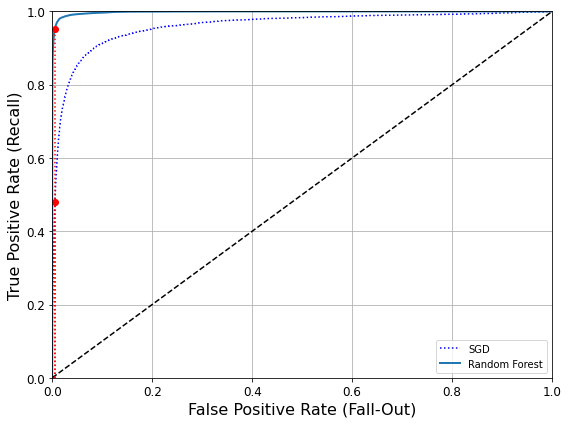

In [51]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest,"Random Forest")

plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right")
save_fig("roc_curve_comparision_plot")
plt.show()

In [52]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [53]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [54]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

#다중 분류

1. OvR(one-vector-the-rest)전략: 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만드는 방법. 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택
2. OvO(one-versus-one)전략: 각 숫자의 조합마다 이진 분류기를 훈련 시키는 것. N * (N-1) / 2개의 클래스 필요

In [55]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [57]:
np.argmax(some_digit_scores)

5

In [58]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
svm_clf.classes_[5]

5

SVC 기반으로 OvR 전략을 사용하는 다중 분류기 만들기

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
len(ovr_clf.estimators_)

10

SGDClassifier 훈련

In [62]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [63]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [64]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

#에러 분석

cross_val_predict()로 예측을 만들고 confusion_matrix()로 오차 행렬 생성

In [69]:
x_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5860,   63,    0,    0,    0,    0,    0,    0,    0,    0],
       [6675,   67,    0,    0,    0,    0,    0,    0,    0,    0],
       [5932,   26,    0,    0,    0,    0,    0,    0,    0,    0],
       [5913,  218,    0,    0,    0,    0,    0,    0,    0,    0],
       [5821,   21,    0,    0,    0,    0,    0,    0,    0,    0],
       [1891, 3530,    0,    0,    0,    0,    0,    0,    0,    0],
       [5796,  122,    0,    0,    0,    0,    0,    0,    0,    0],
       [6251,   14,    0,    0,    0,    0,    0,    0,    0,    0],
       [5741,  110,    0,    0,    0,    0,    0,    0,    0,    0],
       [5903,   46,    0,    0,    0,    0,    0,    0,    0,    0]])

그림 저장: confusion_matrix_plot


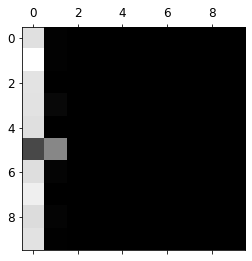

In [68]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
#keepdims=True일때 sum을 실행하고 줄어드는 차원을 1로 채워줌 
#ex) (2,3,4)차원의 행렬에 sum(axis=1)을 실행하면  (3,4)차원으로 바뀌는데
#     sum(axis=1, keepdims=True)를 실행하면 (1,3,4)차원으로 없어지는 차원을 1로 채워줌
norm_conf_mx = comf_mx / row_sums 

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], imgaes_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

#다중 레이블 분류

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilable)

In [ ]:
knn_clf.predict([some_digit])

모든 레이블에 대한 F1점수의 평균 계산

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

#다중 출력 분류
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것

잡음 제거 시스템 만들기

In [72]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

IndexError: ignored

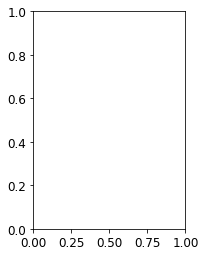

In [73]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()